In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime
import math
import statsmodels.api as sm
import warnings
from IPython.core.interactiveshell import InteractiveShell
from scipy import stats

InteractiveShell.ast_node_interactivity = "all"
warnings.filterwarnings('ignore')

In [2]:
#Importing Files from Competition

games = pd.read_csv('games.csv')
players = pd.read_csv('players.csv')
plays = pd.read_csv('plays.csv')
tackles = pd.read_csv('tackles.csv')

In [3]:
print('Number of Weeks: ', games['week'].nunique())
print('Number of Games: ', games['gameId'].nunique())

Number of Weeks:  9
Number of Games:  136


In [4]:
#Describing Score Metrics

print('Home Team Score: ')
games.homeFinalScore.describe()

print('Visitor Team Score: ')
games.visitorFinalScore.describe()

Home Team Score: 


count    136.000000
mean      22.669118
std        8.659874
min        3.000000
25%       17.000000
50%       22.500000
75%       27.000000
max       49.000000
Name: homeFinalScore, dtype: float64

Visitor Team Score: 


count    136.000000
mean      20.948529
std        9.731446
min        0.000000
25%       14.750000
50%       20.000000
75%       27.000000
max       48.000000
Name: visitorFinalScore, dtype: float64

In [5]:
#Converting gameDate to DateTime for Day of Week Analysis
games['gameDate'] = pd.to_datetime(games['gameDate'])

#Finding Day of Week
games['dayOfWeek'] = games['gameDate'].dt.day_name()

#Denoting if Game is Primetime
games['primeTime'] = 'No'
games.loc[games.dayOfWeek == 'Thursday', 'primeTime'] = 'Yes'
games.loc[games.dayOfWeek == 'Monday', 'primeTime'] = 'Yes'
games.loc[(games.dayOfWeek == 'Sunday') & (games.gameTimeEastern.str[0:2] == '20'), 'primeTime'] = 'Yes'

### Tracking EDA

In [6]:
#Importing Tracking from Week 1
tracking_1 = pd.read_csv('tracking_week_1.csv')
tracking_1['x'] = tracking_1.x.round(2)

tracking_2 = pd.read_csv('tracking_week_2.csv')
tracking_2['x'] = tracking_2.x.round(2)

tracking_3 = pd.read_csv('tracking_week_3.csv')
tracking_3['x'] = tracking_3.x.round(2)

tracking_4 = pd.read_csv('tracking_week_4.csv')
tracking_4['x'] = tracking_4.x.round(2)

tracking_5 = pd.read_csv('tracking_week_5.csv')
tracking_5['x'] = tracking_5.x.round(2)

tracking_6 = pd.read_csv('tracking_week_6.csv')
tracking_6['x'] = tracking_6.x.round(2)

tracking_7 = pd.read_csv('tracking_week_7.csv')
tracking_7['x'] = tracking_7.x.round(2)

tracking_8 = pd.read_csv('tracking_week_8.csv')
tracking_8['x'] = tracking_8.x.round(2)

tracking_9 = pd.read_csv('tracking_week_9.csv')
tracking_9['x'] = tracking_9.x.round(2)

In [7]:
tracking = pd.concat([tracking_1, tracking_2, tracking_3, tracking_4, tracking_5, tracking_6, tracking_7, tracking_8, tracking_9])

### Play Animator

In [8]:
def playAnimator(data):
    color_mapping = {
        'Offense': 'cornsilk',
        'Defense': 'lightblue',
        'football': 'brown',
        'Tackle': 'red',
        'MissedTackle': 'gold',
        'football':'#825736',
        'ballCarrier': 'lime',
        'assist':'darkorange',
        'forcedFumble':'fuchsia'
    }
    
    fig = fig = px.scatter(data, x = 'x', y = 'y', range_x = [0,120], range_y = [0, 53.3],
              color = 'playerType', animation_frame = 'frameId', hover_name = 'displayName',
              color_discrete_map=color_mapping, width=1000, height=565)
    
    fig = fig.add_vrect(x0=0, x1=10, fillcolor = 'gray')
    fig = fig.add_vrect(x0=110, x1=120, fillcolor = 'gray')
    fig = fig.add_vline(x = int(play_data['absoluteYardlineNumber']), line_dash="dash", 
                        line_color="blue", opacity = 0.5)
    fig = fig.add_vline(x = int(play_data['absoluteYardlineNumber']) + int(play_data['yardsToGo']),
                        line_dash="dash", line_color="yellow", opacity = 0.5)
    fig = fig.update_layout(
        plot_bgcolor='#567D46'
    )
    fig = fig.update_yaxes(visible=False)
    fig = fig.update_layout(xaxis=dict(
        tick0=0,
        dtick=10,))
    
    fig = fig.update_traces(marker=dict(size=12,line=dict(width=2,color='black'), opacity=0.9),
                      selector=dict(mode='markers'))
    
    # Set frame duration to 100ms
    fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 100
    
    # Set transition xduration between frames to 0ms
    fig.layout.updatemenus[0].buttons[0].args[1]["transition"]["duration"] = 0
    
    return fig

### Advanced Tracking Data

In [248]:
def advancedTracking(GAMEID, PLAYID):
    try:
        data = tracking[(tracking.gameId == GAMEID) & (tracking.playId == PLAYID)]
        tackle_data = tackles[(tackles.gameId == GAMEID)&(tackles.playId == PLAYID)].reset_index(drop = True)
        play_data = plays[(plays.gameId == GAMEID)&(plays.playId == PLAYID)].reset_index(drop=True)
        
        #Creates Empty Lists for Tacklers, Missed Tackles, Assits, and Forced Fumbles
        tackles_list = []
        missed_tackles = []
        assists = []
        forcedFumbles = []
        
        #Iterates through the Tackle Data and Identifies the above categories, appends to the list
        for row in range(len(tackle_data)):
            if tackle_data.iloc[row]['tackle'] == 1:
                tackles_list.append(tackle_data.iloc[row].nflId)
            if tackle_data.iloc[row]['assist'] == 1:
                assists.append(tackle_data.iloc[row].nflId)
            if tackle_data.iloc[row]['forcedFumble'] == 1:
                forcedFumbles.append(tackle_data.iloc[row].nflId)
            if tackle_data.iloc[row]['pff_missedTackle'] == 1:
                missed_tackles.append(tackle_data.iloc[row].nflId)
               
        
        #Identifies the Ball Carrier
        ball_carrier = int(play_data['ballCarrierId'])
        
        #Labels Players in tracking data that are ball carrier, tackler, assist, FF, and missed Tackles
        data.loc[data['nflId'] == ball_carrier, 'tag'] = 'ballCarrier'
        
        data.loc[data['nflId'].isin(tackles_list), 'tackle'] = 1
        data.loc[data['nflId'].isin(assists), 'assist'] = 1
        data.loc[data['nflId'].isin(forcedFumbles), 'forcedFumble'] = 1
        data.loc[data['nflId'].isin(missed_tackles), 'missedTackle'] = 1
        
        ball_carrier_xy = []
        ball_data = data[data.tag == 'ballCarrier']
        all_tacklers = tackles_list + missed_tackles + forcedFumbles + assists
        
        #Finds distance from tacklers to the ball_carrier
        for frame in list(data.frameId.sort_values().unique()):
            
            #Get xy coords for ball_carrier
            ball_carrier_xy = ball_data[ball_data.frameId == frame][['x','y']].values.flatten().tolist()
            
            for player in all_tacklers:
                #Get xy coords for tackler
                tackler_xy = data[(data.nflId == player)&(data.frameId == frame)][['x','y']].values.flatten().tolist()
        
                #Finds Distance from Ball Carrier to Tackler and appends it in dataframe
                distance_from_carrier = math.dist(ball_carrier_xy, tackler_xy)
                data.loc[(data.frameId == frame) & (data.nflId == player), 'distanceFromCarrier'] = distance_from_carrier
            
            #Get xy coords for ball_carier
            carrier_xy = data[(data.displayName == 'football')&(data.frameId == frame)][['x','y']].values.flatten().tolist()
        
            #Finds Distance from Ball Carrier to Tackler and appends it in dataframe
            distance_from_carrier = math.dist(ball_carrier_xy, carrier_xy)
            data.loc[(data.frameId == frame) & (data.displayName == 'football'), 'distanceFromCarrier'] = distance_from_carrier
                
        football_xy = []
        football_data = data[data.displayName == 'football']
        
        #Finds distance from ballcarier to the football to know when he has the ball
        for frame in list(data.frameId.sort_values().unique()):
            
            #Get xy coords for ball_carrier
            football_xy = football_data[football_data.frameId == frame][['x','y']].values.flatten().tolist()
            
            #Get xy coords for ball_carier
            carrier_xy = data[(data.tag == 'ballCarrier')&(data.frameId == frame)][['x','y']].values.flatten().tolist()
        
            #Finds Distance from Ball Carrier to Football and appends it in dataframe
            distance_from_football = math.dist(football_xy, carrier_xy)
            data.loc[(data.frameId == frame) & (data.tag == 'ballCarrier'), 'distanceFromCarrier'] = distance_from_football
        
        #Assigns "club" as tackler or ball_carrier to signify difference from normal defender or offender
        data.loc[(data.distanceFromCarrier < 2)&(data.tackle == 1), 'club'] = 'Tackle'
        data.loc[(data.distanceFromCarrier < 2)&(data.missedTackle == 1), 'club'] = 'MissedTackle'
        data.loc[(data.distanceFromCarrier < 2)&(data.assist == 1), 'club'] = 'assist'
        data.loc[(data.distanceFromCarrier < 0.5)&(data.forcedFumble == 1), 'club'] = 'forcedFumble'
        
        data.loc[(data.distanceFromCarrier < 1.5)&(data.tag == 'ballCarrier'), 'club'] = 'ballCarrier'
        data.loc[(data.distanceFromCarrier < 1.5)&(data.displayName == 'football'), ['x','y']] = np.nan
        
        #Creates NA players for tacklers and ballCarrier when they are not actively under that "club"
        num_of_missed = data[data.missedTackle==1]['nflId'].nunique()
        num_of_tackles = data[data.tackle == 1]['nflId'].nunique()
        num_of_assists = data[data.assist == 1]['nflId'].nunique()
        num_of_fumbles = data[data.forcedFumble == 1]['nflId'].nunique()
        
        for frame in list(data.frameId.sort_values().unique()):
            
            missing_players = num_of_missed - data[(data.frameId == frame)&(data.club == 'MissedTackle')]['missedTackle'].sum()
            for i in range(int(missing_players)):
                data = pd.concat([data, pd.DataFrame({'gameId':GAMEID, 'playId':PLAYID, 'frameId':frame, 'club':'MissedTackle'}, index = [0])])
                
            missing_players = num_of_tackles - data[(data.frameId == frame)&(data.club == 'Tackle')]['tackle'].sum()
            for i in range(int(missing_players)):
                data = pd.concat([data, pd.DataFrame({'gameId':GAMEID, 'playId':PLAYID, 'frameId':frame, 'club':'Tackle'}, index = [0])])
                
            missing_players = num_of_assists - data[(data.frameId == frame)&(data.club == 'assist')]['assist'].sum()
            for i in range(int(missing_players)):
                data = pd.concat([data, pd.DataFrame({'gameId':GAMEID, 'playId':PLAYID, 'frameId':frame, 'club':'assist'}, index = [0])])
        
            missing_players = num_of_fumbles - data[(data.frameId == frame)&(data.club == 'forcedFumble')]['forcedFumble'].sum()
            for i in range(int(missing_players)):
                data = pd.concat([data, pd.DataFrame({'gameId':GAMEID, 'playId':PLAYID, 'frameId':frame, 'club':'forcedFumble'}, index = [0])])
                
            if not math.isnan(data[(data.frameId == frame)&(data.displayName == 'football')]['x']):
                data = pd.concat([data, pd.DataFrame({'gameId':GAMEID, 'playId':PLAYID, 'frameId':frame, 'club':'ballCarrier'}, index = [0])])
        
        
        #Replacing Team names with Offense and Defense
        
        data['club'] = data['club'].replace(play_data.iloc[0]['possessionTeam'], 'Offense')
        data['club'] = data['club'].replace(play_data.iloc[0]['defensiveTeam'], 'Defense')
        
        #Replaces 'club' with playerType to be more specific
        data = data.rename(columns = {'club':'playerType'})
        
        return data
    except: 
        return None

### Advanced Tracking EDA

In [265]:
df = pd.DataFrame()
#All Week 1 Games as a List
game_list = tracking['gameId'].unique()
i = 0 
#Iterates through each play of each game and adds advanced tracking data
for game in game_list:
    print(f'{i} of 136 Completed')
    play_list = tracking[tracking.gameId == game]['playId'].unique()
    i += 1
    for play in play_list:
        df_1 = advancedTracking(game, play)
        df = pd.concat([df, df_1])

0 of 136 Completed
1 of 136 Completed
2 of 136 Completed
3 of 136 Completed
4 of 136 Completed
5 of 136 Completed
6 of 136 Completed
7 of 136 Completed
8 of 136 Completed
9 of 136 Completed
10 of 136 Completed
11 of 136 Completed
12 of 136 Completed
13 of 136 Completed
14 of 136 Completed
15 of 136 Completed
16 of 136 Completed
17 of 136 Completed
18 of 136 Completed
19 of 136 Completed
20 of 136 Completed
21 of 136 Completed
22 of 136 Completed
23 of 136 Completed
24 of 136 Completed
25 of 136 Completed
26 of 136 Completed
27 of 136 Completed
28 of 136 Completed
29 of 136 Completed
30 of 136 Completed
31 of 136 Completed
32 of 136 Completed
33 of 136 Completed
34 of 136 Completed
35 of 136 Completed
36 of 136 Completed
37 of 136 Completed
38 of 136 Completed
39 of 136 Completed
40 of 136 Completed
41 of 136 Completed
42 of 136 Completed
43 of 136 Completed
44 of 136 Completed
45 of 136 Completed
46 of 136 Completed
47 of 136 Completed
48 of 136 Completed
49 of 136 Completed
50 of 136 

In [291]:
df.to_csv('AllGames_wAdvancedTracking.csv', index = False)

In [292]:
print('hi')

hi


In [274]:
tackle_location = df[(df.event == 'tackle')&((df.playerType == 'ballCarrier'))].reset_index(drop = True)
tackle_location.loc[tackle_location.playDirection == 'left', 'x'] = 120 - tackle_location.x
tackle_location.loc[tackle_location.playDirection == 'left', 'y'] = 53.3 - tackle_location.y
tackle_location['x']  = tackle_location['x']-10

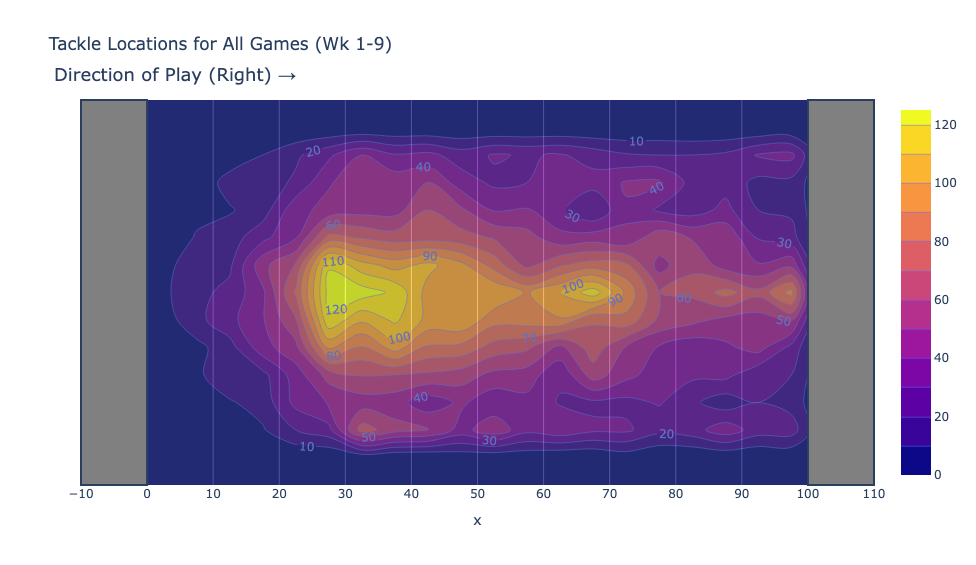

In [277]:
fig = px.density_contour(tackle_location, x="x", y="y", width=1000, height=565, title = 'Tackle Locations for All Games (Wk 1-9)')
fig = fig.update_traces(contours_coloring="fill", contours_showlabels = True, opacity = 0.7)
fig = fig.add_vrect(x0=-10, x1=0, fillcolor = 'gray')
fig = fig.add_vrect(x0=100, x1=110, fillcolor = 'gray')
fig = fig.update_layout(plot_bgcolor='#567D46')
fig = fig.update_yaxes(visible=False)
fig = fig.update_layout(xaxis=dict(tick0=0,dtick=10,))
fig = fig.add_annotation(text="Direction of Play (Right) →",xref="paper", yref="paper",x=-.035, y=1.1, showarrow=False)
fig = fig.update_annotations(font=dict(size=18))
fig

In [290]:
tackle_location = df[(df.event == 'tackle')&((df.playerType == 'Tackle'))].reset_index(drop = True)
tackle_location['s'] = tackle_location['s']*2.04545
tackle_location['s'].describe()

count    7112.000000
mean        5.321273
std         3.640265
min         0.000000
25%         2.454540
50%         4.592035
75%         7.527256
max        19.247685
Name: s, dtype: float64

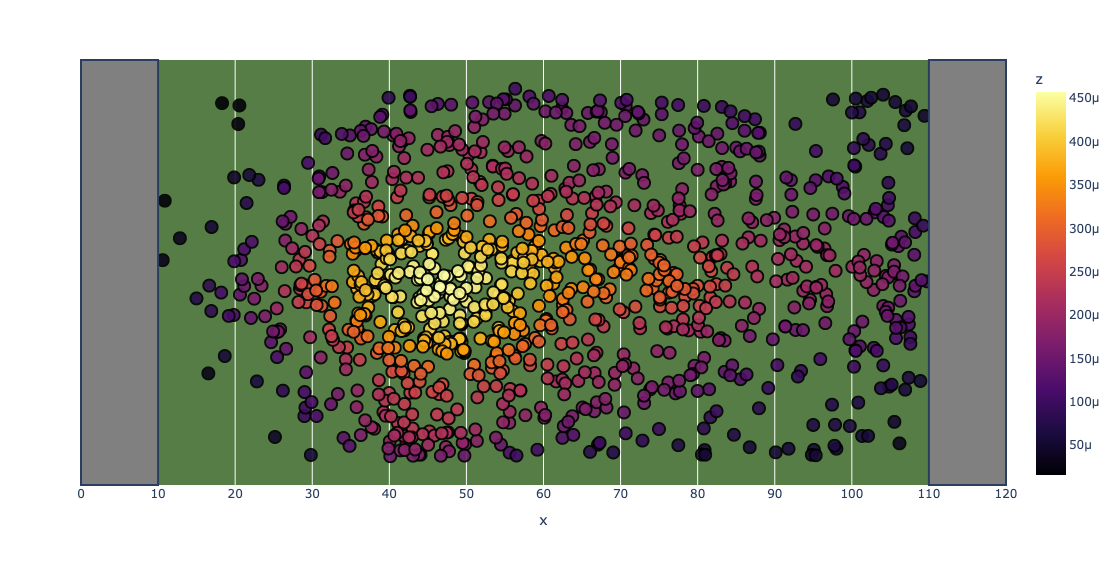

In [155]:
kernel = stats.gaussian_kde([tackle_location.x, tackle_location.y])
tackle_location['z'] = kernel([tackle_location.x, tackle_location.y])
fig = px.scatter(tackle_location, x = 'x', y = 'y', color = 'z', width=1000, height=565, color_continuous_scale=px.colors.sequential.Inferno)


fig = fig.add_vrect(x0=0, x1=10, fillcolor = 'gray')
fig = fig.add_vrect(x0=110, x1=120, fillcolor = 'gray')
fig = fig.update_layout(plot_bgcolor='#567D46')
fig = fig.update_yaxes(visible=False)
fig = fig.update_layout(xaxis=dict(
    tick0=0,
    dtick=10,))

fig = fig.update_traces(marker=dict(size=12,line=dict(width=2,color='black'), opacity=0.9),
                      selector=dict(mode='markers'))

fig

28

In [10]:
# random_game = int(df['gameId'].sample())
# random_play = int(df[df.gameId == random_game]['playId'].sample())
df2 = tracking[(tracking.gameId == 2022091105)&(df.playId == 2132)]
playAnimator(df2)

NameError: name 'df' is not defined

In [119]:
df2[df2.event == 'first_contact']['frameId'].min()

35